# Simulator: Optimal and Naive Protocols

This notebook goes over the use of the simulator class to simulate both 'naive' and optimal (in the linear-response sense) control protocols, as well as introduces the concept of how to extend the simulator interface to simulate more exotic time-dependent behaviour

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='hls')

from fokker_planck.simulator.simulator import BreathingSimulator
from fokker_planck.types.basetypes import BoundaryCondition
import fokker_planck.forceFunctions as ff

# We'll use the same configuration parameters as in the previous example
config = {
    "D": 1.0,
    "dx": 0.01,
    "dt": 0.00025,
    "x_min": -2.0,
    "x_max": 2.0,
    "boundary_cond": BoundaryCondition.HardWall
}

In this example, we know the functional form of the so-called generalized friction coefficient, which varies with trap strength as

$$ \zeta(\lambda) = \lambda^{3/2} $$

which implies that an optimal, minimum-dissipation protocol will proceed with a control parameter veolcity

$$ \dot{\lambda}_{\rm opt} \propto \zeta^{-1/2} = k^{-3/4} $$

Where the proportionality is fixed by the constraint that the protocol be completed in a fixed total time $\tau$.

In this model, we simply need to provide a function to the ```DynamicSimulator1D``` subclass called ```build_friction_array``` that will generate the friction value, as a function of control parameter (```self.lambda_array```) and the parent class contains the logic necessary to actually complete the protocol.

In [2]:
# To actually simulate the system, we need to create a simulator object
# Initial and final trap strengths
k_i, k_f = 2.0, 8.0

simulator_naive = BreathingSimulator(
    config, k_i, k_f, ff.harmonic_force, ff.harmonic_energy
)

simulator_opt = BreathingSimulator(
    config, k_i, k_f, ff.harmonic_force, ff.harmonic_energy
)

In [3]:
# And then we can run the simulation for both naive (constant velocity)
# and optimized (constant dissipation rate) protocols

result_naive = simulator_naive.run_simulation(tau=1.0, mode="naive")
result_optimal = simulator_opt.run_simulation(tau=1.0, mode="optimal")

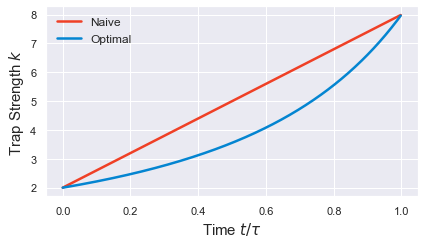

In [5]:
# Both of these results are SimulationResult objects

# To look at the control protocols in detail, we can plot them
result_optimal.__dict__.keys()
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(result_naive.time, result_naive.CP, label="Naive", color=sns.xkcd_rgb["tomato"], linewidth=2.5)
ax.plot(result_optimal.time, result_optimal.CP, label="Optimal", color=sns.xkcd_rgb["cerulean"], linewidth=2.5)

ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Time $t/\tau$", fontsize=15)
ax.set_ylabel(r"Trap Strength $k$", fontsize=15)
plt.tight_layout()
plt.show()


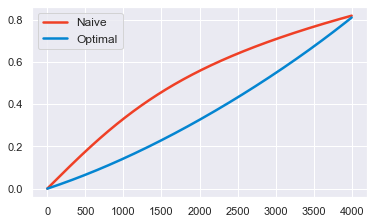

In [6]:
# We can also look at the average work required to complete these protocols
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.plot(result_naive._sim.fpe.work_tracker, color=sns.xkcd_rgb['tomato'], linewidth=2.5, label="Naive")
ax.plot(result_optimal._sim.fpe.work_tracker, color=sns.xkcd_rgb['cerulean'], linewidth=2.5, label="Optimal")
ax.legend(fontsize=12)


In [7]:
result_optimal._sim.fpe.work_accumulator / result_naive._sim.fpe.work_accumulator

0.989308434257189